In [1]:
# gpu imports
from cuml.cluster import KMeans
import cudf
import cupy as cp

# cpu imports
import pandas as pd
from datetime import datetime
from astropy.io import fits
import sunpy
import sunpy.map
import sunpy.sun
from sunpy.map.maputils import all_coordinates_from_map
from sunpy.coordinates import get_horizons_coord

import astropy.units as u
from astropy.visualization.mpl_normalize import ImageNormalize
import glob
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
class synchronic_map():
    def __init__(self):
        pass

    def plot_map_object(self, map_object, cmap):

        ny, nx = map_object.data.shape
        print(map_object.plot_settings)
        map_object.plot_settings['cmap'] = plt.get_cmap(cmap)
        # map_object.plot_settings['norm'] = ImageNormalize(map_object.data)
        map_object.plot_settings['norm'] = colors.LogNorm()
        print(map_object.plot_settings)

        plt.figure(figsize=(10, 5))
        ax = plt.subplot(projection=map_object.wcs)
        im = map_object.plot()
        lon, lat = ax.coords
        lon.set_coord_type("longitude")
        lon.coord_wrap = 180
        lon.set_format_unit(u.deg)
        lat.set_coord_type("latitude")
        lat.set_format_unit(u.deg)
        lon.set_axislabel('Heliographic Longitude', minpad=0.8)
        lat.set_axislabel('Heliographic Latitude', minpad=0.9)
        lon.set_ticks(spacing=25 * u.deg, color='k')
        lat.set_ticks(spacing=15 * u.deg, color='k')
        plt.colorbar(im, ax=ax)

        # Reset the view to pixel centers
        _ = ax.axis((0, nx, 0, ny))
        plt.show()

In [3]:
cp.random.seed(seed=2)

path_to_files = 'fits_data/polar_coronal_holes/'
filenames_171 = sorted(glob.glob(path_to_files+'fullSunMap_171_eit_l1_*'))
filenames_195 = sorted(glob.glob(path_to_files+'fullSunMap_195_eit_l1_*'))
filenames_304 = sorted(glob.glob(path_to_files+'fullSunMap_304_eit_l1_*'))
n = 1
shape = (n, 360, 720, 3)
data_cpu = np.empty(shape)


for i in range(n):
    data_cpu[i,:,:,0] = sunpy.map.Map(filenames_171[i]).data
    data_cpu[i,:,:,1] = sunpy.map.Map(filenames_195[i]).data
    data_cpu[i,:,:,2] = sunpy.map.Map(filenames_304[i]).data

# move data to gpu array    
data = cp.array(data_cpu)
# flatten image arrays for segmentation
data_reshaped = data.reshape((data.shape[0], data.shape[1]*data.shape[2], data.shape[3]))
print(data.shape)
print(data_reshaped.shape)

(1, 360, 720, 3)
(1, 259200, 3)


In [4]:
x = data_reshaped[0:].copy()
# get non-nan indices (using pandas due to some cudf oddities)
non_nan_indices = pd.DataFrame(cp.asnumpy(x.reshape(x.shape[0]*x.shape[1], x.shape[2]))).dropna().index
# drop nans from training data
X_t = cudf.DataFrame.from_gpu_matrix(x.reshape(x.shape[0]*x.shape[1], x.shape[2])).iloc[non_nan_indices]
print(X_t.head())
X_t = cp.asarray(X_t.as_gpu_matrix())

               0           1           2
4407  181.752688  240.137589  206.302585
4408  181.108215  239.693168  204.171149
4409  180.702036  238.590900  202.730747
4410  180.321540  237.428464  201.352728
4411  179.935287  236.269222  199.978265


In [5]:
ks = 50
elbow_arr = cp.empty(ks-2)
ctr = 0
p = tqdm.tqdm
for k in p(range(2, ks)):

    # set up the kmeans classification by specifying the number of clusters 
    km = KMeans(n_clusters=k)
    # begin iteratively computing the position of the two clusters
    km.fit(X_t)

    centroids = km.cluster_centers_
    pred_clusters = km.predict(X_t)
    gdf_pred_clusters = cudf.DataFrame.from_gpu_matrix(X_t)
    gdf_pred_clusters['cluster_idx'] = pred_clusters

    gdf_clusters = cudf.DataFrame.from_gpu_matrix(centroids)
    gdf_clusters['cluster_idx'] = gdf_clusters.index

    gdf_pred_clusters = gdf_pred_clusters.merge(gdf_clusters, how="left", on='cluster_idx')
    gdf_pred_clusters['euclid_dist'] = \
        ((gdf_pred_clusters['0_x'] - gdf_pred_clusters['0_y']) ** 2 + \
         (gdf_pred_clusters['1_x'] - gdf_pred_clusters['1_y']) ** 2 + \
         (gdf_pred_clusters['2_x'] - gdf_pred_clusters['2_y']) ** 2) ** 0.5

    elbow_arr[ctr] = gdf_pred_clusters['euclid_dist'].sum()
    ctr += 1


100%|██████████| 48/48 [00:38<00:00,  1.26it/s]


In [6]:
def compute_elbow(elbow_arr):
    curve = cp.asnumpy(elbow_arr)
    nPoints = len(curve)
    allCoord = cp.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / cp.sqrt(cp.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    rep1, rep2 = cp.repeat(lineVecNorm[0], nPoints), cp.repeat(lineVecNorm[1],nPoints)
    rep = cp.empty((nPoints, 2))
    rep[:,0] = rep1
    rep[:,1] = rep2
    scalarProduct = cp.sum(vecFromFirst * rep, axis=1)
    vecFromFirstParallel = cp.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = cp.sqrt(cp.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = cp.argmax(distToLine)
    return idxOfBestPoint


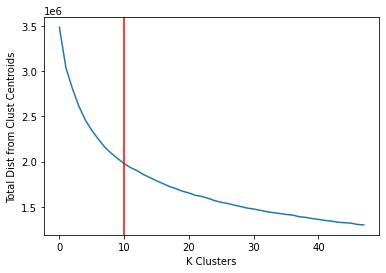

In [7]:
idxOfBestPoint = compute_elbow(elbow_arr)
plt.plot([i for i in range(len(elbow_arr))], cp.asnumpy(elbow_arr))
plt.xlabel("K Clusters")
plt.ylabel("Total Dist from Clust Centroids")
plt.axvline(idxOfBestPoint, c='r')

In [8]:
print("Optimal K-Clusters:", idxOfBestPoint)

Optimal K-Clusters: 10


In [9]:
km = KMeans(n_clusters=idxOfBestPoint)
#km = KMeans(n_clusters=8)
km.fit(X_t)

KMeans(handle=<cuml.common.handle.Handle object at 0x7fbb1be1d1b0>, n_clusters=10, max_iter=300, tol=0.0001, verbose=2, random_state=1, init='scalable-k-means++', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cupy')

9.0
{'cmap': 'gray', 'norm': <matplotlib.colors.Normalize object at 0x7fbadbc4bda0>, 'interpolation': 'nearest', 'origin': 'lower'}
{'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7fbb1d9f6dd8>, 'norm': <matplotlib.colors.LogNorm object at 0x7fbadbc8da90>, 'interpolation': 'nearest', 'origin': 'lower'}


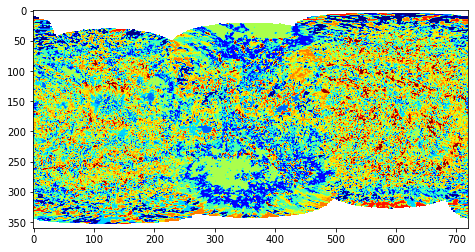

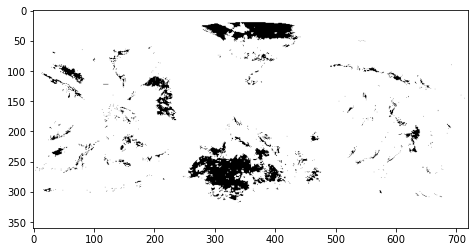

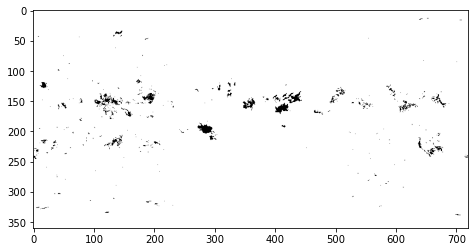

/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


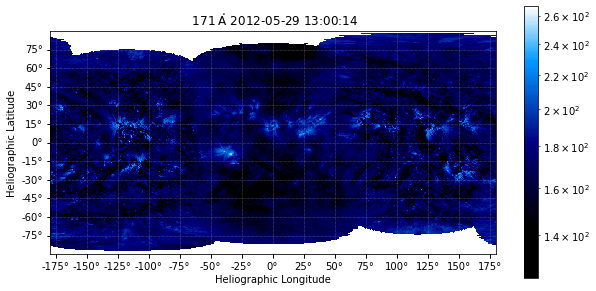

{'cmap': 'gray', 'norm': <matplotlib.colors.Normalize object at 0x7fbadb8ca3c8>, 'interpolation': 'nearest', 'origin': 'lower'}
{'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7fbb1d9f6e80>, 'norm': <matplotlib.colors.LogNorm object at 0x7fbadb96fb38>, 'interpolation': 'nearest', 'origin': 'lower'}


/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


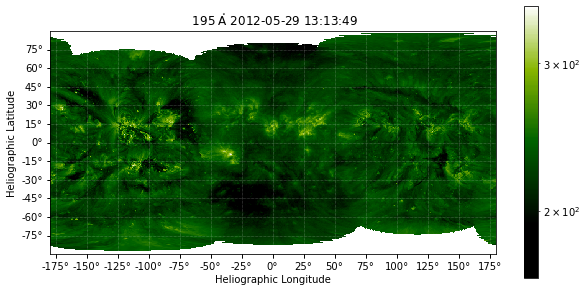

{'cmap': 'gray', 'norm': <matplotlib.colors.Normalize object at 0x7fbadb5a4c50>, 'interpolation': 'nearest', 'origin': 'lower'}
{'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7fbb1da31390>, 'norm': <matplotlib.colors.LogNorm object at 0x7fbadb8e4748>, 'interpolation': 'nearest', 'origin': 'lower'}


/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


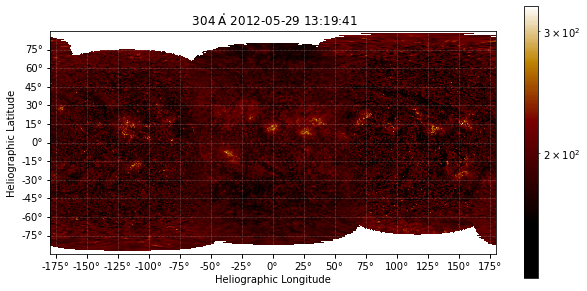

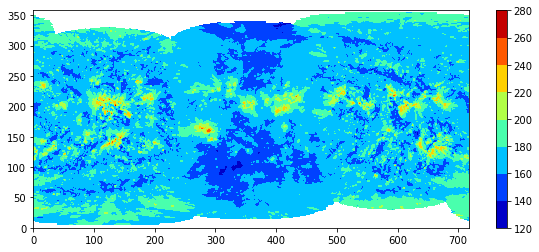

In [12]:
infer_index = 0
ch_class_slice = 5
ar_class_slice = 2

###
x_test = data_reshaped[infer_index].copy()
# get non-nan indices (using pandas due to some cudf oddities)
non_nan_indices = pd.DataFrame(cp.asnumpy(x_test)).dropna().index
# drop nans from training data
X_test = cudf.DataFrame.from_gpu_matrix(x_test).iloc[non_nan_indices]
X_test = cp.asarray(X_test.as_gpu_matrix())
###

predictions = km.predict(X_test)
gdf_x_test = cudf.DataFrame.from_gpu_matrix(x_test)
gdf_x_test['class'] = cp.nan
gdf_x_test['class'].iloc[non_nan_indices] = predictions

plt.figure(figsize=(8,4))
preds = cp.asarray(gdf_x_test['class']).reshape(data.shape[1], data.shape[2]).copy()
plt.imshow(cp.asnumpy(cp.flipud(preds)))
plt.set_cmap('jet')

plt.figure(figsize=(8,4))
preds = cp.asarray(gdf_x_test['class']).reshape(data.shape[1], data.shape[2]).copy()
plt.imshow(cp.asnumpy(cp.flipud(preds==ch_class_slice)))
plt.set_cmap('Greys')

plt.figure(figsize=(8,4))
preds = cp.asarray(gdf_x_test['class']).reshape(data.shape[1], data.shape[2]).copy()
plt.imshow(cp.asnumpy(cp.flipud(preds==ar_class_slice)))
plt.set_cmap('Greys')

sync_class = synchronic_map()
cmaps = ['sohoeit171', 'sohoeit195', 'sohoeit304']
sync_map_171 = sunpy.map.Map(filenames_171[infer_index])
sync_class.plot_map_object(sync_map_171, cmaps[0])
sync_map_195 = sunpy.map.Map(filenames_195[infer_index])
sync_class.plot_map_object(sync_map_195, cmaps[1])
sync_map_304 = sunpy.map.Map(filenames_304[infer_index])
sync_class.plot_map_object(sync_map_304, cmaps[2])

plt.figure(figsize=(9.75,4))
plt.contourf(cp.asnumpy(data[infer_index,1:,2:,0]))
plt.set_cmap('jet')
plt.colorbar()

In [11]:
def compute_iou(truth, pred):
    overlap = truth * pred # Logical AND
    union = truth + pred # Logical OR

    return overlap.sum() / float(union.sum())

truth = preds==class_slice
rand = cp.random.choice([False,True], size=preds.shape, p=[0.1, 0.9])
truth *= rand
pred = preds==ch_class_slice

print("Notional IOU Score:", compute_iou(truth, pred))

NameError: name 'class_slice' is not defined

In [ ]:
path_to_files = 'masks/'
filenames_masks = sorted(glob.glob(path_to_files+'EUVI*'))
mask_idx = 0
print(filenames_masks[mask_idx])
mask = sunpy.io.fits.read(filenames_masks[mask_idx])
mask_arr = mask[0][0]
plt.imshow(mask_arr)